In [1]:
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import torch
import math
import networkx as nx
from tqdm import tqdm
from PIL import Image
import json
import copy
from torch.utils.data import DataLoader, random_split
from crp.image import imgify, vis_opaque_img, plot_grid
from torch.utils.data import DataLoader
from crp.concepts import ChannelConcept

from expbasics.helper import get_attributions, get_model_etc, to_name
from expbasics.crp_attribution import CRPAttribution
from expbasics.network import load_model, train_network, accuracy_per_class
from expbasics.background_dataset import get_biased_loader, BackgroundDataset
from expbasics.visualizations import my_plot_grid
from expbasics.test_dataset_background import TestDataset
from measures0_to_2_new import AllMeasures
%reload_ext autoreload
%autoreload 2

tensor(1.1788) tensor(-0.0441) tensor(0.0224) tensor(1.2093) tensor(-0.1758) tensor(0.0277)


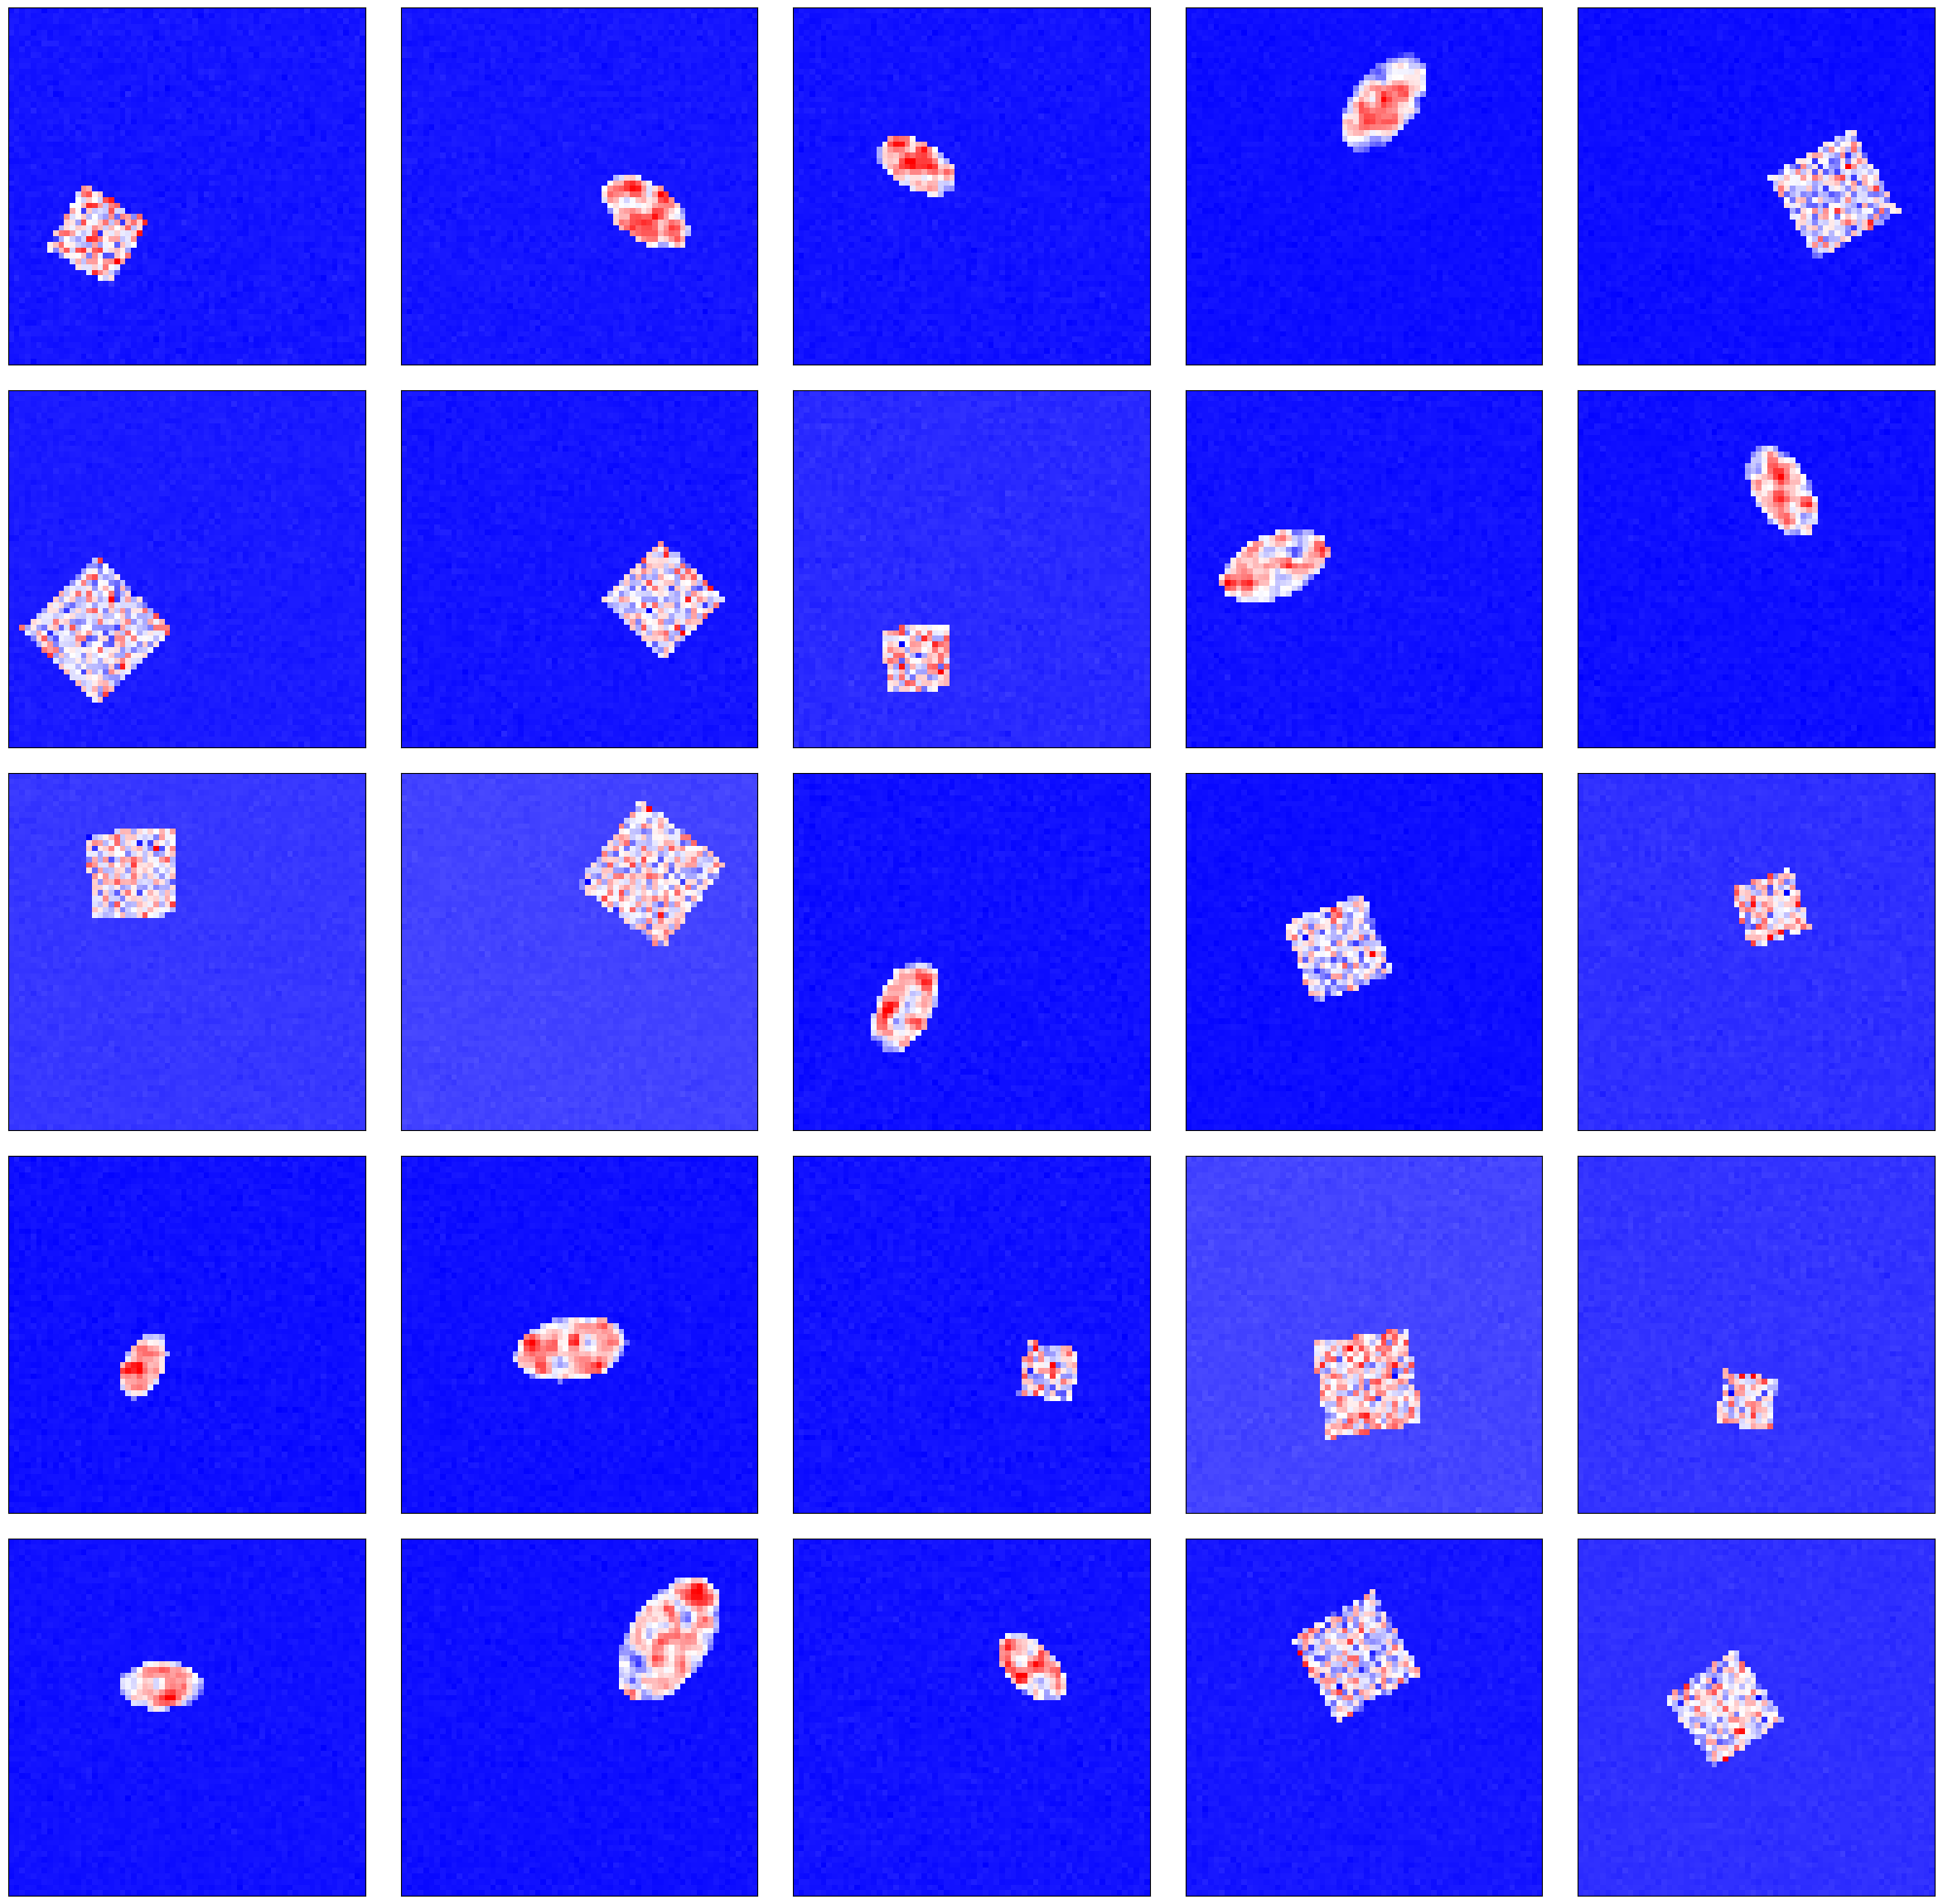

In [312]:

#ds  = BackgroundDataset(0,0.5)
size = 5
loader = get_biased_loader(1.0, 0.5,size*size, verbose=False)
imgs, ts = next(iter(loader))
imgs1ind = torch.where(ts == 1)
imgs0ind = torch.where(ts == 0)
print(imgs[imgs1ind].max(),imgs[imgs1ind].min(),imgs[imgs1ind].mean(),imgs[imgs0ind].max(),imgs[imgs0ind].min(),imgs[imgs0ind].mean())
my_plot_grid(imgs.view(size,size,64,64),size,size,6, norm=False)

In [304]:
BIASES = [0.0,0.98]#,0.5,0.9,0.98]
# BIASES = list(np.round(np.linspace(0, 1, 21), 3))
SEEDS = [6]

NAME = "background"
rand_gen = torch.Generator().manual_seed(43)

BATCH_SIZE = 128
LEARNING_RATE = 0.001
EPOCHS = 2
STRENGTH = 0.5
IMAGE_PATH = "../dsprites-dataset/images"
accs = []
for bias in BIASES:
    for seed in SEEDS:
        ds = BackgroundDataset(bias, STRENGTH, img_path=IMAGE_PATH)
        trainds, testds, _ = random_split(ds, [0.1, 0.01, 0.89], generator=rand_gen)
        train_loader = DataLoader(
            trainds, batch_size=BATCH_SIZE, shuffle=True, generator=rand_gen
        )
        test_loader = DataLoader(
            testds, batch_size=BATCH_SIZE, shuffle=True, generator=rand_gen
        )
        name = to_name(bias, seed)
        model = train_network(
            train_loader,
            bias,
            STRENGTH,
            NAME,
            BATCH_SIZE,
            load=True,
            retrain=True,
            learning_rate=LEARNING_RATE,
            epochs=EPOCHS,
            num_it=seed,
            seeded=True,
            disable=False,
        )

cpu
background_b0i0_6.pickle
EPOCH 1:


385it [00:48,  7.93it/s, acc=58.2, batch=300, epoch=1, loss=0.67]


loss epoch: 0.6659898656606674
EPOCH 2:


385it [00:54,  7.11it/s, acc=61.7, batch=300, epoch=2, loss=0.64]


loss epoch: 0.6374113470315933
best loss:  0.6374113470315933  last loss:  0.6374113470315933  best epoch:  model_1_0.0
cpu
background_b0i98_6.pickle
EPOCH 1:


385it [00:56,  6.78it/s, acc=98.9, batch=300, epoch=1, loss=0.19]

loss epoch: 0.19308998554944992
best loss:  0.19308998554944992  last loss:  0.19308998554944992  best epoch:  model_0_0.98


0.0 tensor([[-0.4629, -0.0411]], grad_fn=<AddmmBackward0>) tensor([[-0.4571, -0.0441]], grad_fn=<AddmmBackward0>)
0.98 tensor([[ 2.3129, -1.9024]], grad_fn=<AddmmBackward0>) tensor([[-2.7132,  0.7233]], grad_fn=<AddmmBackward0>)


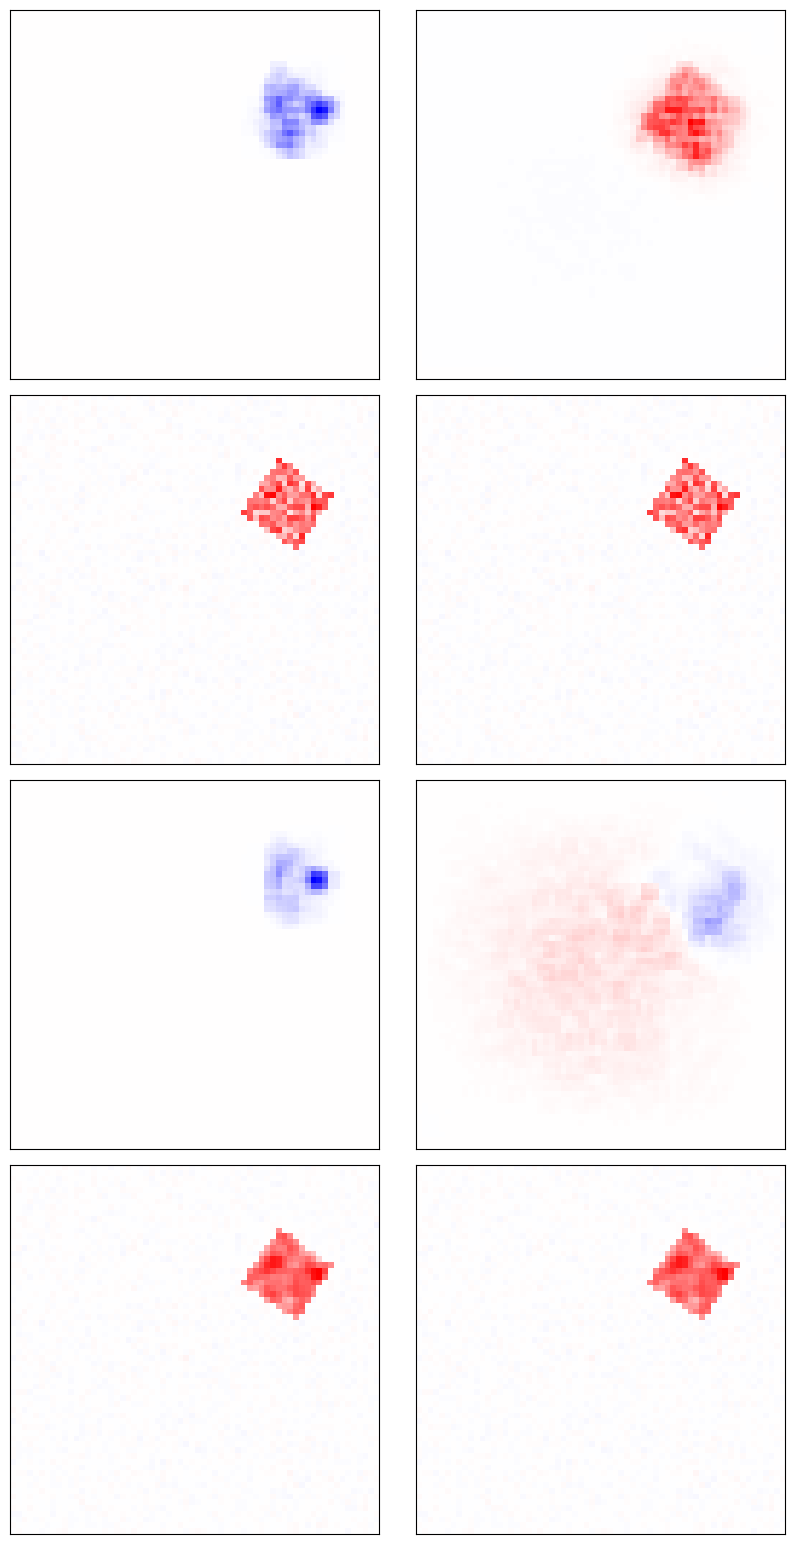

In [306]:
LAYER_NAME = "convolutional_layers.6"
biases = [0.0,0.98] #BIASES
seeds = [6] #SEEDS
unbds = BackgroundDataset(0.0, STRENGTH, img_path=IMAGE_PATH)

ms = AllMeasures(IMAGE_PATH, 128)
iind = 48099
importances = []
images = torch.zeros(4, len(biases)*len(seeds), 64,64)
count = 0
for bias in biases:
    for seed in seeds:
        model = load_model(NAME, bias, seed)
        model_name = to_name(bias, seed)
        crpa = CRPAttribution(model, unbds, NAME, model_name)   
        
        #rel = crpa.image_info(iind, verbose=True)   
        image_0 = unbds.load_image_wm(iind, False)
        image_1 = unbds.load_image_wm(iind, True)

        predv_0 = model(image_0)
        predv_1 = model(image_1)
        print(bias, predv_0, predv_1)
        # classification W=0, W=1
        predi_0 = int(predv_0.data.max(1)[1][0])
        predi_1 = int(predv_1.data.max(1)[1][0])
        # heatmaps W=0, W=1
        heatmap_0 = ms.heatmaps(image_0, crpa, predi_0)
        heatmap_1 = ms.heatmaps(image_1, crpa, predi_1)
        images[0,count] = heatmap_0.sum(dim = 0)
        images[1,count] = image_0.detach()
        images[2,count] = heatmap_1.sum(dim = 0)
        images[3,count] = image_1.detach()
        count += 1
my_plot_grid(images,4, len(biases)*len(seeds), 5, norm=False)


making new test dataset
computing feature vis
len dataset 1000
Running Analysis...


100%|██████████| 8/8 [00:02<00:00,  3.96it/s]


100%|██████████| 10/10 [00:00<00:00, 2173.55it/s]
/home/lilli/miniconda3/envs/mt/lib/python3.10/site-packages/crp/image.py:288: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


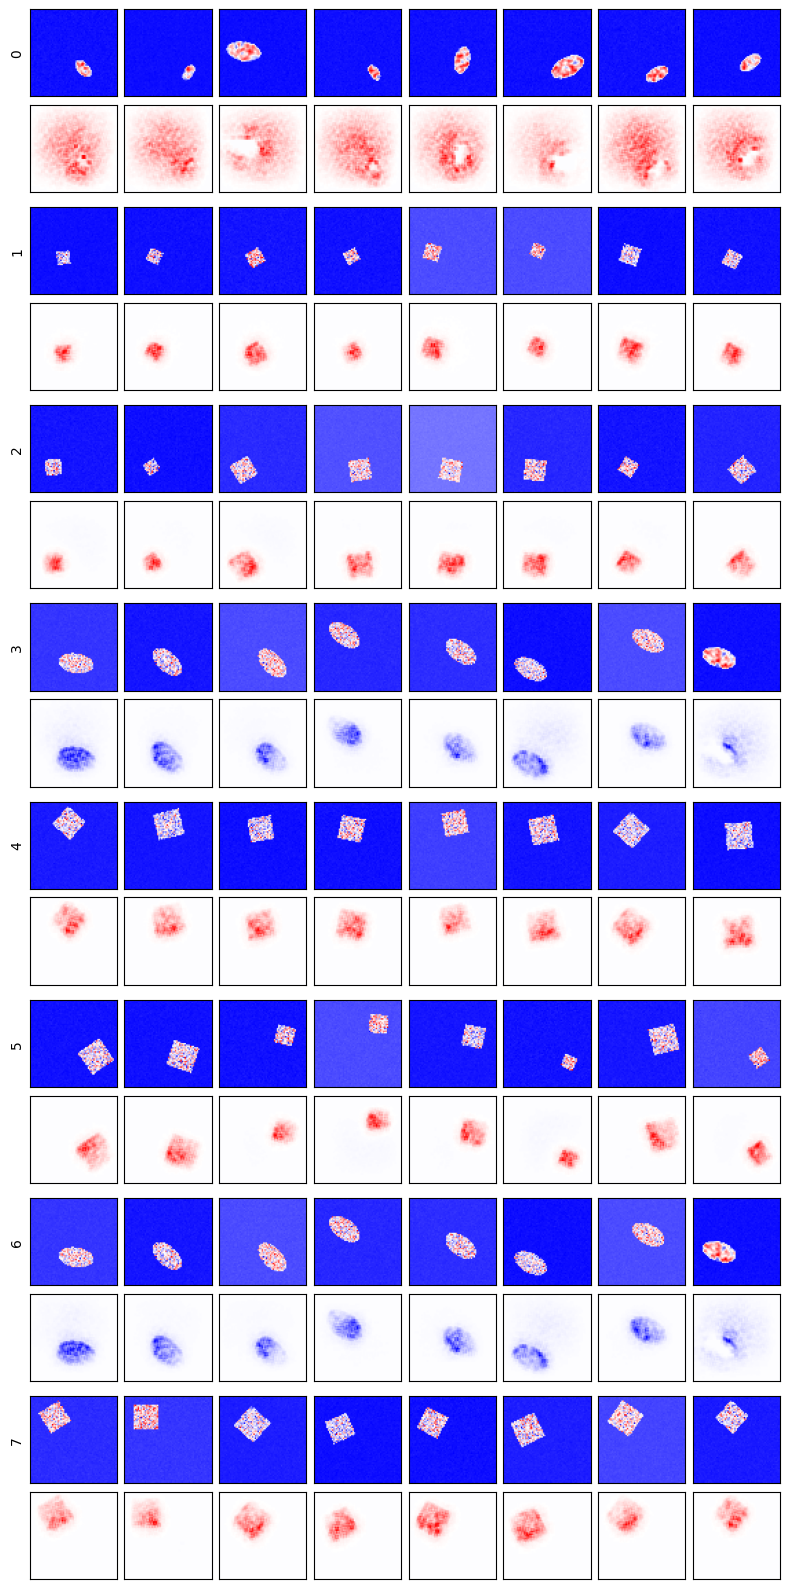

In [309]:
bias = 0.98
seed = 6
testds = TestDataset(length=1000, im_dir="blur_corr_background")
model = load_model(NAME, bias, seed)
model_name = f"background_{to_name(bias, seed)}"
crpa = CRPAttribution(model, testds, NAME, model_name)
res = crpa.compute_feature_vis()
layer = "convolutional_layers.6"  # "linear_layers.0" #
neurons = range(8)
crpa.make_all_references(
    layer, neurons, relact="relevance"
)  # "convolutional_layers.6" "linear_layers.0"

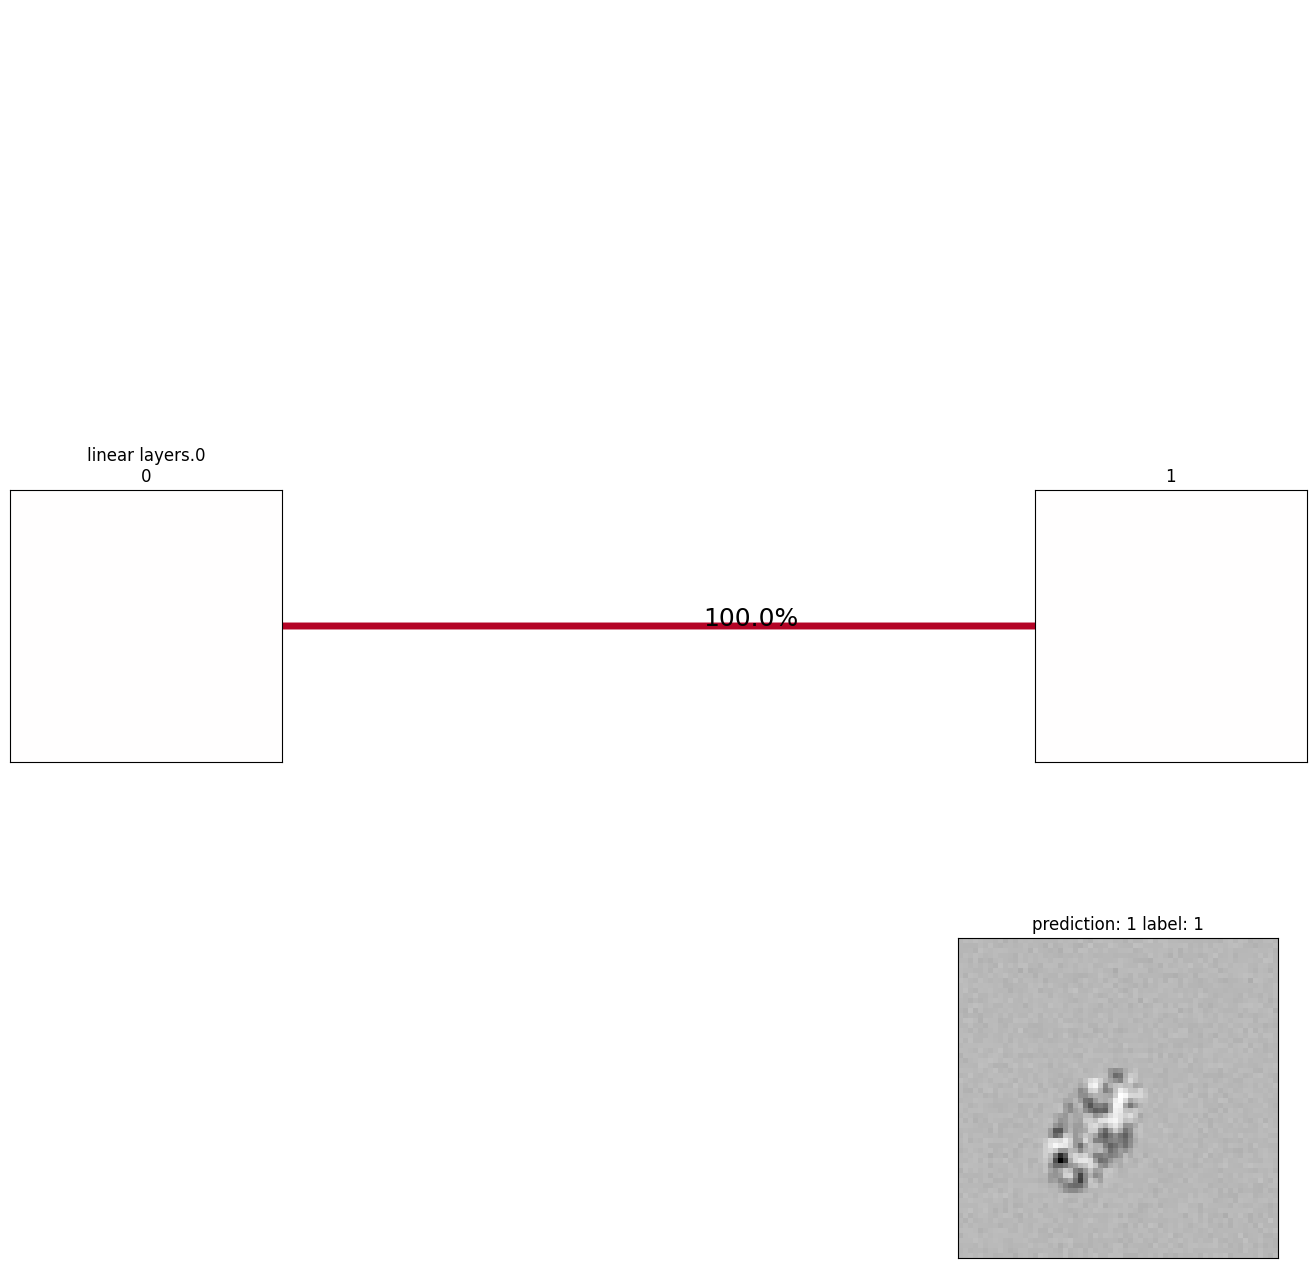

In [274]:
from expbasics.plotting import draw_graph_with_images
#crpa.image_info(601, True)
node_labels, edges, images = crpa.complete_relevance_graph(929)
draw_graph_with_images(node_labels, edges, images)

In [275]:
import gzip
from time import sleep
from sklearn.metrics import matthews_corrcoef, normalized_mutual_info_score

max_target = "sum"
with open(
    f"{crpa.fv_path}/RelMax_{max_target}_normed/convolutional_layers.6_data.npy", "rb"
) as f:
    data = np.load(f)
with open(
    f"{crpa.fv_path}/RelMax_{max_target}_normed/convolutional_layers.6_rel.npy", "rb"
) as f:
    relevances = np.load(f)
len_set = 40

info = np.zeros((8, len_set, 4), dtype=np.int64)
overlap = np.zeros((8, 5))
for neuron in range(8):
    indices = data[:len_set, neuron]

    for i, ind in enumerate(indices):
        img, label = testds[ind]
        (latents, has_watermark, _) = testds.get_item_info(ind)
        info[neuron, i, 0] = ind
        info[neuron, i, 1] = label
        info[neuron, i, 2] = int(has_watermark)
    with_wm_count = np.count_nonzero(info[neuron, :, 2] == 1)
    ell_count = np.count_nonzero(info[neuron, :, 1] == 1)
    """ print(
        info[neuron, :, 2],with_wm_count,info[neuron, :, 1]
    ) """
    overlap[neuron, 0] = with_wm_count / (
        2
        * max(
            np.count_nonzero(info[neuron, :, 1] == 1),
            np.count_nonzero(info[neuron, :, 1] == 0),
        )
    )
    overlap[neuron, 1] = normalized_mutual_info_score(
        info[neuron, :, 1], info[neuron, :, 2]
    )
    corr_matrix = np.corrcoef(info[neuron, :, 1], info[neuron, :, 2])
    corr = corr_matrix[0, 1]
    R_sq = corr**2
    if np.isnan(R_sq):
        R_sq = 0.0
    overlap[neuron, 2] = R_sq
    overlap[neuron, 3] = (
        (
            max(
                np.count_nonzero(info[neuron, :, 2] == 1),
                np.count_nonzero(info[neuron, :, 2] == 0),
            )
        )
        - (
            max(
                np.count_nonzero(info[neuron, :, 1] == 1),
                np.count_nonzero(info[neuron, :, 1] == 0),
            )
        )
    ) / 40
    overlap[neuron, 4] = (
        max(
            (
                np.count_nonzero(info[neuron, :, 2] == 1)
                - np.count_nonzero(info[neuron, :, 1] == 1)
            ),(
                np.count_nonzero(info[neuron, :, 2] == 0)
                - np.count_nonzero(info[neuron, :, 1] == 0)
            )
        )
        / 40
    )

print(overlap)

[[ 0.    1.    0.    0.    0.  ]
 [ 0.    1.    0.    0.    0.  ]
 [ 0.    1.    0.    0.    0.  ]
 [ 0.    1.    0.    0.    0.  ]
 [ 0.    1.    0.    0.    0.  ]
 [ 0.    1.    0.    0.    0.  ]
 [ 0.25  0.    0.   -0.5   0.5 ]
 [ 0.    1.    0.    0.    0.  ]]


/home/lilli/miniconda3/envs/mt/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/lilli/miniconda3/envs/mt/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/lilli/miniconda3/envs/mt/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/lilli/miniconda3/envs/mt/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/lilli/miniconda3/envs/mt/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/lilli/miniconda3/envs/mt/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:

In [222]:
import pickle
with open(f"test_background/labels.pickle", "rb") as f:
    labels = pickle.load(f)

accuracy below 85%: 12
bad biases:  [[1, 0.06, 69.0946044921875], [1, 0.12, 68.26042938232422], [1, 0.18, 66.16480255126953], [1, 0.2, 79.10478210449219], [1, 0.28, 62.258392333984375], [1, 0.3, 51.06815719604492], [1, 0.32, 67.93489074707031], [4, 0.32, 51.06815719604492], [1, 0.38, 68.01627349853516], [1, 0.42, 51.06815719604492], [1, 0.46, 51.06815719604492], [1, 0.48, 51.06815719604492]]


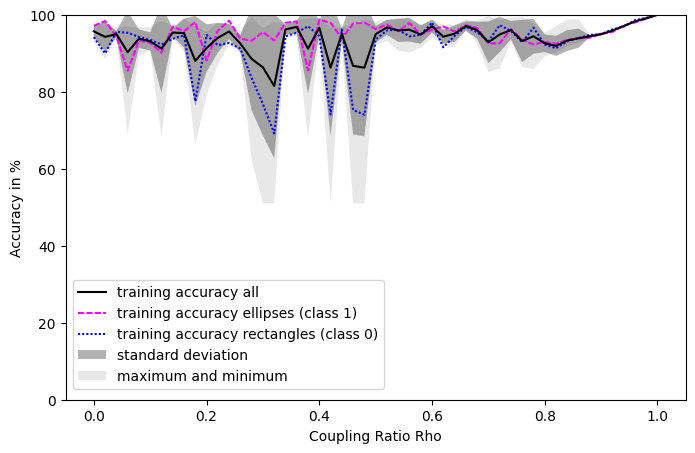

In [21]:
from expbasics.visualizations import plot_accuracies

MODEL_ZOO_INFOS_PATH = "outputs/unlocalized3.json"  #noise_pos_accuracies #conv_ground_truth # recompute_accuracies #model_accuracies #blub_accuracies

bad = plot_accuracies(MODEL_ZOO_INFOS_PATH, 85, num_it=5, intervened=False)

accuracy below 85%: 29
bad biases:  [[1, 0.04, 70.030517578125], [4, 0.04, 81.5462875366211], [1, 0.06, 59.409969329833984], [2, 0.06, 48.952186584472656], [0, 0.08, 80.28484344482422], [1, 0.1, 60.264495849609375], [1, 0.12, 66.87690734863281], [1, 0.18, 66.16480255126953], [2, 0.18, 75.0762939453125], [1, 0.2, 76.5615463256836], [0, 0.22, 80.52899169921875], [1, 0.26, 77.23295593261719], [1, 0.28, 48.972530364990234], [2, 0.28, 65.02542877197266], [1, 0.3, 48.93183898925781], [1, 0.32, 67.93489074707031], [4, 0.32, 48.93183898925781], [2, 0.36, 53.38758850097656], [1, 0.38, 66.83621215820312], [1, 0.42, 48.93183898925781], [1, 0.46, 48.93183898925781], [1, 0.48, 48.93183898925781], [1, 0.5, 81.5462875366211], [3, 0.6, 66.20549011230469], [2, 0.68, 77.13123321533203], [3, 0.68, 84.47608947753906], [1, 0.7, 52.227874755859375], [1, 0.72, 79.4506607055664], [1, 0.74, 83.47914123535156]]


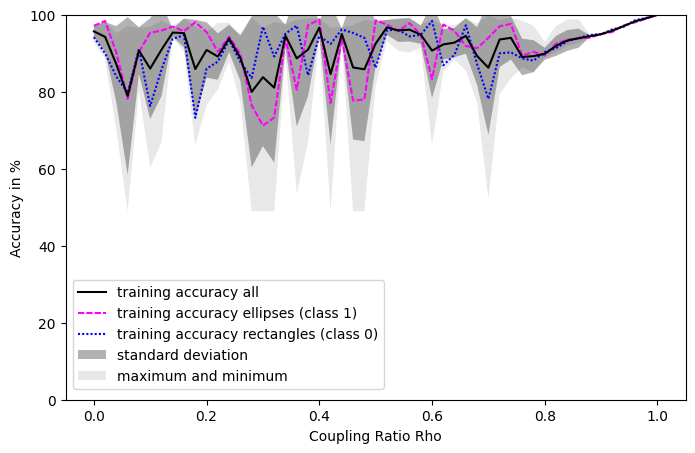

In [12]:

MODEL_ZOO_INFOS_PATH = "outputs/unlocalized2.json"  #noise_pos_accuracies #conv_ground_truth # recompute_accuracies #model_accuracies #blub_accuracies

bad = plot_accuracies(MODEL_ZOO_INFOS_PATH, 85, num_it=5, intervened=False)

accuracy below 80%: 12
bad biases:  [[1, 0.06, 69.0946044921875], [1, 0.12, 68.26042938232422], [1, 0.18, 66.16480255126953], [1, 0.2, 79.10478210449219], [1, 0.28, 62.258392333984375], [1, 0.3, 51.06815719604492], [1, 0.32, 67.93489074707031], [4, 0.32, 51.06815719604492], [1, 0.38, 68.01627349853516], [1, 0.42, 51.06815719604492], [1, 0.46, 51.06815719604492], [1, 0.48, 51.06815719604492]]


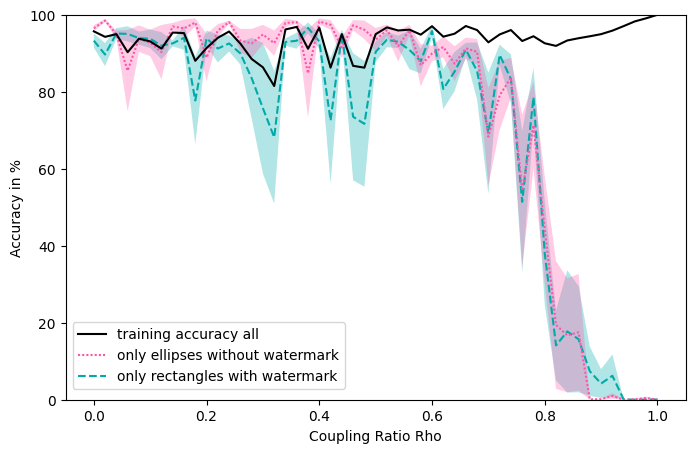

In [22]:
bad = plot_accuracies(MODEL_ZOO_INFOS_PATH, 80, num_it=5, intervened=True)

In [26]:

with open("outputs/unlocalized3.json", "r") as f:
    accuracies = json.load(f)
makes_sense = [any(
        [
            accuracies[to_name(bias, seed)]["train_accuracy"][2] < 90
            for seed in range(0, 5)
        ]
    ) for bias in list(np.round(np.linspace(0, 1, 51), 3))]
np.count_nonzero(makes_sense)

19